In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [45]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
class GRU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.gru = nn.GRU(config.input_size, config.hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(config.hidden_size//2, config.output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        gru_out, hidden = self.gru(x, hidden)
        last_output = gru_out[:, -1, :]
        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

# trainer 구현

In [11]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")
    
  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [29]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 2000    # healthy data를 몇개를 쓸지 (이부분 실험군 조정을 하자.)
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_size = 19        # 처음 input의 차원의 개수 (feature수와 같다)
  hidden_size=512        # GRU hidden vector size
  output_size = 2        # output 차원의 개수

config = Config()

In [30]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [31]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [32]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


In [33]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 2000
failure(1)의 개수 : 1569


In [34]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [35]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [36]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [37]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 2141
Total number of data samples in valid_loader: 713
Total number of data samples in test_loader: 714


In [38]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [39]:
# model, optimizer, loss_function 구현하고 결합시키기
model = GRU(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [23]:
# save path 지정 잘해줄 것!!!!!!!!(2000일떄, 3000일때, 잘 보고 조정 잘하자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/2000_GRU') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 3/3 [00:00<00:00, 450.77it/s]


Model saved
TRAIN LOSS = 0.0027782585174332486, TRAIN ACC = 0.625408687529192, 
VALID LOSS = 0.002565867018064309, VALID ACC = 0.6886395511921458, 
epoch 2


100%|██████████| 3/3 [00:00<00:00, 429.86it/s]


Model saved
TRAIN LOSS = 0.0025089592200915763, TRAIN ACC = 0.6809901914992994, 
VALID LOSS = 0.002471695190392236, VALID ACC = 0.7096774193548387, 
epoch 3


100%|██████████| 3/3 [00:00<00:00, 430.30it/s]


TRAIN LOSS = 0.0024128711039860746, TRAIN ACC = 0.6950023353573097, 
VALID LOSS = 0.0023946805555389106, VALID ACC = 0.699859747545582, 
epoch 4


100%|██████████| 3/3 [00:00<00:00, 55.38it/s]


Model saved
TRAIN LOSS = 0.002339015965815851, TRAIN ACC = 0.7015413358243812, 
VALID LOSS = 0.0022013302772275864, VALID ACC = 0.7138849929873773, 
epoch 5


100%|██████████| 3/3 [00:00<00:00, 414.18it/s]


Model saved
TRAIN LOSS = 0.0021439383988734553, TRAIN ACC = 0.7206912657636618, 
VALID LOSS = 0.002160171807063077, VALID ACC = 0.7447405329593267, 
epoch 6


100%|██████████| 3/3 [00:00<00:00, 405.87it/s]


TRAIN LOSS = 0.002086079632885152, TRAIN ACC = 0.7356375525455394, 
VALID LOSS = 0.002129658032600542, VALID ACC = 0.7194950911640954, 
epoch 7


100%|██████████| 3/3 [00:00<00:00, 428.89it/s]


Model saved
TRAIN LOSS = 0.0019873994942415213, TRAIN ACC = 0.747781410555815, 
VALID LOSS = 0.001995954490142651, VALID ACC = 0.7489481065918654, 
epoch 8


100%|██████████| 3/3 [00:00<00:00, 456.07it/s]


Model saved
TRAIN LOSS = 0.0018517221596017167, TRAIN ACC = 0.7725361980382999, 
VALID LOSS = 0.0018403518835257682, VALID ACC = 0.7601683029453016, 
epoch 9


100%|██████████| 3/3 [00:00<00:00, 432.64it/s]


Model saved
TRAIN LOSS = 0.0016924603583377302, TRAIN ACC = 0.7916861279775805, 
VALID LOSS = 0.0019519582787870858, VALID ACC = 0.761570827489481, 
epoch 10


100%|██████████| 3/3 [00:00<00:00, 403.26it/s]


Model saved
TRAIN LOSS = 0.0017341970979805473, TRAIN ACC = 0.7800093414292387, 
VALID LOSS = 0.001734271415654272, VALID ACC = 0.7769985974754559, 
epoch 11


100%|██████████| 3/3 [00:00<00:00, 418.05it/s]


Model saved
TRAIN LOSS = 0.0015925356212591023, TRAIN ACC = 0.7935544138253152, 
VALID LOSS = 0.001672862998900875, VALID ACC = 0.7840112201963534, 
epoch 12


100%|██████████| 3/3 [00:00<00:00, 462.90it/s]


TRAIN LOSS = 0.0016252191364069177, TRAIN ACC = 0.7930873423633816, 
VALID LOSS = 0.001712748705086835, VALID ACC = 0.7755960729312763, 
epoch 13


100%|██████████| 3/3 [00:00<00:00, 406.33it/s]


TRAIN LOSS = 0.0015685978279888825, TRAIN ACC = 0.8019617001401215, 
VALID LOSS = 0.001893228350983094, VALID ACC = 0.7517531556802244, 
epoch 14


100%|██████████| 3/3 [00:00<00:00, 452.46it/s]


TRAIN LOSS = 0.0015694436794238245, TRAIN ACC = 0.7870154133582438, 
VALID LOSS = 0.0016529976402058007, VALID ACC = 0.7798036465638148, 
epoch 15


100%|██████████| 3/3 [00:00<00:00, 407.12it/s]


Model saved
TRAIN LOSS = 0.0014993160448025344, TRAIN ACC = 0.7986921999065857, 
VALID LOSS = 0.0015639021971784167, VALID ACC = 0.788218793828892, 
epoch 16


100%|██████████| 3/3 [00:00<00:00, 422.53it/s]


TRAIN LOSS = 0.0014131487056174494, TRAIN ACC = 0.8038299859878562, 
VALID LOSS = 0.0016343858181845088, VALID ACC = 0.7854137447405329, 
epoch 17


100%|██████████| 3/3 [00:00<00:00, 423.81it/s]


TRAIN LOSS = 0.0013342821071883999, TRAIN ACC = 0.8103689864549276, 
VALID LOSS = 0.0016207559162236195, VALID ACC = 0.7868162692847125, 
epoch 18


100%|██████████| 3/3 [00:00<00:00, 404.62it/s]


TRAIN LOSS = 0.0014017844439555083, TRAIN ACC = 0.8085007006071929, 
VALID LOSS = 0.0015546715861450239, VALID ACC = 0.7812061711079944, 
epoch 19


100%|██████████| 3/3 [00:00<00:00, 410.13it/s]


Model saved
TRAIN LOSS = 0.0013219629671461168, TRAIN ACC = 0.8155067725361981, 
VALID LOSS = 0.001572366182131988, VALID ACC = 0.7896213183730715, 
epoch 20


100%|██████████| 3/3 [00:00<00:00, 335.66it/s]


TRAIN LOSS = 0.001331956043581938, TRAIN ACC = 0.8117702008407286, 
VALID LOSS = 0.0017467780668304143, VALID ACC = 0.7812061711079944, 
epoch 21


100%|██████████| 3/3 [00:00<00:00, 397.44it/s]


TRAIN LOSS = 0.0012784626566322537, TRAIN ACC = 0.814105558150397, 
VALID LOSS = 0.0015976683120406527, VALID ACC = 0.782608695652174, 
epoch 22


100%|██████████| 3/3 [00:00<00:00, 410.25it/s]


Model saved
TRAIN LOSS = 0.001249683273556855, TRAIN ACC = 0.8169079869219991, 
VALID LOSS = 0.0015129240916788495, VALID ACC = 0.7966339410939691, 
epoch 23


100%|██████████| 3/3 [00:00<00:00, 464.38it/s]


TRAIN LOSS = 0.0011830333096576817, TRAIN ACC = 0.8243811303129379, 
VALID LOSS = 0.0015681543992244512, VALID ACC = 0.791023842917251, 
epoch 24


100%|██████████| 3/3 [00:00<00:00, 425.90it/s]


TRAIN LOSS = 0.0011936095706328563, TRAIN ACC = 0.8253152732368052, 
VALID LOSS = 0.0016432531167547967, VALID ACC = 0.7840112201963534, 
epoch 25


100%|██████████| 3/3 [00:00<00:00, 433.79it/s]


Model saved
TRAIN LOSS = 0.0012174078595242953, TRAIN ACC = 0.8201774871555348, 
VALID LOSS = 0.0015454136806985607, VALID ACC = 0.7980364656381487, 
epoch 26


100%|██████████| 3/3 [00:00<00:00, 416.49it/s]


TRAIN LOSS = 0.0010834532828600482, TRAIN ACC = 0.8271835590845399, 
VALID LOSS = 0.0015434487337484266, VALID ACC = 0.7966339410939691, 
epoch 27


100%|██████████| 3/3 [00:00<00:00, 431.20it/s]


TRAIN LOSS = 0.0011619736676681605, TRAIN ACC = 0.8276506305464736, 
VALID LOSS = 0.0016746189952063862, VALID ACC = 0.791023842917251, 
epoch 28


100%|██████████| 3/3 [00:00<00:00, 405.68it/s]


Model saved
TRAIN LOSS = 0.0011765991051806183, TRAIN ACC = 0.8220457730032695, 
VALID LOSS = 0.0015468440249792154, VALID ACC = 0.7994389901823282, 
epoch 29


100%|██████████| 3/3 [00:00<00:00, 405.61it/s]


Model saved
TRAIN LOSS = 0.0010596667979711242, TRAIN ACC = 0.844465203176086, 
VALID LOSS = 0.0015757000295845021, VALID ACC = 0.8106591865357644, 
epoch 30


100%|██████████| 3/3 [00:00<00:00, 391.30it/s]


TRAIN LOSS = 0.0009991372789750863, TRAIN ACC = 0.8435310602522186, 
VALID LOSS = 0.001565139139852216, VALID ACC = 0.7952314165497896, 
epoch 31


100%|██████████| 3/3 [00:00<00:00, 419.29it/s]


TRAIN LOSS = 0.0010607193308085942, TRAIN ACC = 0.8425969173283513, 
VALID LOSS = 0.0015690527741404102, VALID ACC = 0.8036465638148668, 
epoch 32


100%|██████████| 3/3 [00:00<00:00, 401.87it/s]


Model saved
TRAIN LOSS = 0.0009293414161674111, TRAIN ACC = 0.864549276039234, 
VALID LOSS = 0.00150923725598992, VALID ACC = 0.8359046283309958, 
epoch 33


100%|██████████| 3/3 [00:00<00:00, 369.46it/s]


Model saved
TRAIN LOSS = 0.0009571534139093313, TRAIN ACC = 0.8981784212984587, 
VALID LOSS = 0.0014553301631986342, VALID ACC = 0.8485273492286115, 
epoch 34


100%|██████████| 3/3 [00:00<00:00, 404.63it/s]


TRAIN LOSS = 0.0008373201686831514, TRAIN ACC = 0.919196637085474, 
VALID LOSS = 0.0014504495208761635, VALID ACC = 0.8387096774193549, 
epoch 35


100%|██████████| 3/3 [00:00<00:00, 402.69it/s]


Model saved
TRAIN LOSS = 0.0008243719087143692, TRAIN ACC = 0.9229332087809435, 
VALID LOSS = 0.0014631782892208446, VALID ACC = 0.8639551192145862, 
epoch 36


100%|██████████| 3/3 [00:00<00:00, 371.04it/s]


TRAIN LOSS = 0.0006573305216029335, TRAIN ACC = 0.9341429238673518, 
VALID LOSS = 0.001407680722138992, VALID ACC = 0.8513323983169705, 
epoch 37


100%|██████████| 3/3 [00:00<00:00, 424.31it/s]


Model saved
TRAIN LOSS = 0.0006640245846530534, TRAIN ACC = 0.9327417094815507, 
VALID LOSS = 0.0013863256235109305, VALID ACC = 0.8681626928471248, 
epoch 38


100%|██████████| 3/3 [00:00<00:00, 379.43it/s]


Model saved
TRAIN LOSS = 0.0005896419864400199, TRAIN ACC = 0.9397477814105558, 
VALID LOSS = 0.0015000548804123973, VALID ACC = 0.8723702664796634, 
epoch 39


100%|██████████| 3/3 [00:00<00:00, 398.63it/s]


TRAIN LOSS = 0.0005779299834575235, TRAIN ACC = 0.9430172816440916, 
VALID LOSS = 0.001637014525133965, VALID ACC = 0.8569424964936886, 
epoch 40


100%|██████████| 3/3 [00:00<00:00, 419.89it/s]


TRAIN LOSS = 0.0006649997198431362, TRAIN ACC = 0.9369453526389537, 
VALID LOSS = 0.001396391117556065, VALID ACC = 0.8667601683029453, 
epoch 41


100%|██████████| 3/3 [00:00<00:00, 406.24it/s]


TRAIN LOSS = 0.0005761580746177199, TRAIN ACC = 0.9444184960298926, 
VALID LOSS = 0.001513411378459208, VALID ACC = 0.8611500701262272, 
epoch 42


100%|██████████| 3/3 [00:00<00:00, 442.89it/s]


TRAIN LOSS = 0.0005958468863363858, TRAIN ACC = 0.9434843531060252, 
VALID LOSS = 0.0014062415583772378, VALID ACC = 0.8723702664796634, 
epoch 43


100%|██████████| 3/3 [00:00<00:00, 390.94it/s]


TRAIN LOSS = 0.0005389094136965046, TRAIN ACC = 0.948155067725362, 
VALID LOSS = 0.0016202357758312038, VALID ACC = 0.8541374474053296, 
epoch 44


100%|██████████| 3/3 [00:00<00:00, 405.48it/s]


Model saved
TRAIN LOSS = 0.0005594411397692981, TRAIN ACC = 0.9486221391872957, 
VALID LOSS = 0.0014951116239539704, VALID ACC = 0.8807854137447405, 
epoch 45


100%|██████████| 3/3 [00:00<00:00, 404.22it/s]


TRAIN LOSS = 0.0005917635540547965, TRAIN ACC = 0.946753853339561, 
VALID LOSS = 0.001524523924644331, VALID ACC = 0.8569424964936886, 
epoch 46


100%|██████████| 3/3 [00:00<00:00, 438.55it/s]


TRAIN LOSS = 0.0007410253468154469, TRAIN ACC = 0.9290051377860813, 
VALID LOSS = 0.0016307202161277995, VALID ACC = 0.8457223001402524, 
epoch 47


100%|██████████| 3/3 [00:00<00:00, 419.68it/s]


TRAIN LOSS = 0.00060701076183181, TRAIN ACC = 0.9406819243344232, 
VALID LOSS = 0.0013054418697597938, VALID ACC = 0.876577840112202, 
epoch 48


100%|██████████| 3/3 [00:00<00:00, 458.63it/s]


TRAIN LOSS = 0.0004732160959940879, TRAIN ACC = 0.9602989257356376, 
VALID LOSS = 0.001540712186698325, VALID ACC = 0.876577840112202, 
epoch 49


100%|██████████| 3/3 [00:00<00:00, 410.70it/s]


TRAIN LOSS = 0.0003762054476766929, TRAIN ACC = 0.9649696403549743, 
VALID LOSS = 0.0015384907642220047, VALID ACC = 0.879382889200561, 
epoch 50


100%|██████████| 3/3 [00:00<00:00, 421.52it/s]


TRAIN LOSS = 0.000300973401496701, TRAIN ACC = 0.9733769266697805, 
VALID LOSS = 0.0017270679059235947, VALID ACC = 0.8723702664796634, 
epoch 51


100%|██████████| 3/3 [00:00<00:00, 443.61it/s]


Model saved
TRAIN LOSS = 0.00030541638697992134, TRAIN ACC = 0.9715086408220458, 
VALID LOSS = 0.0015926683350331653, VALID ACC = 0.8821879382889201, 
epoch 52


100%|██████████| 3/3 [00:00<00:00, 448.03it/s]


TRAIN LOSS = 0.0002838139592320604, TRAIN ACC = 0.978514712751051, 
VALID LOSS = 0.0017255599836480567, VALID ACC = 0.8751753155680224, 
epoch 53


100%|██████████| 3/3 [00:00<00:00, 407.40it/s]


TRAIN LOSS = 0.0002618464512949734, TRAIN ACC = 0.9766464269033162, 
VALID LOSS = 0.0016917930328160483, VALID ACC = 0.8751753155680224, 
epoch 54


100%|██████████| 3/3 [00:00<00:00, 420.96it/s]


TRAIN LOSS = 0.00027642998233653294, TRAIN ACC = 0.9789817842129845, 
VALID LOSS = 0.0017818266429205597, VALID ACC = 0.8681626928471248, 
epoch 55


100%|██████████| 3/3 [00:00<00:00, 424.07it/s]


Model saved
TRAIN LOSS = 0.0003182610087114091, TRAIN ACC = 0.9724427837459131, 
VALID LOSS = 0.001775975899475654, VALID ACC = 0.8877980364656382, 
epoch 56


100%|██████████| 3/3 [00:00<00:00, 444.61it/s]


TRAIN LOSS = 0.0003472167488739124, TRAIN ACC = 0.9719757122839795, 
VALID LOSS = 0.0019241339862764635, VALID ACC = 0.8723702664796634, 
epoch 57


100%|██████████| 3/3 [00:00<00:00, 447.74it/s]


TRAIN LOSS = 0.00026851655486475245, TRAIN ACC = 0.978514712751051, 
VALID LOSS = 0.0016399244105163831, VALID ACC = 0.8737727910238429, 
epoch 58


100%|██████████| 3/3 [00:00<00:00, 420.43it/s]


Model saved
TRAIN LOSS = 0.00023595460319507906, TRAIN ACC = 0.9803829985987856, 
VALID LOSS = 0.0014053391290078825, VALID ACC = 0.8948106591865358, 
epoch 59


100%|██████████| 3/3 [00:00<00:00, 431.07it/s]


TRAIN LOSS = 0.00024222170030163137, TRAIN ACC = 0.9817842129845866, 
VALID LOSS = 0.0016766565879297458, VALID ACC = 0.8821879382889201, 
epoch 60


100%|██████████| 3/3 [00:00<00:00, 434.22it/s]


TRAIN LOSS = 0.0002677618573336666, TRAIN ACC = 0.9771134983652499, 
VALID LOSS = 0.0016041300239937502, VALID ACC = 0.8835904628330996, 
epoch 61


100%|██████████| 3/3 [00:00<00:00, 431.42it/s]


TRAIN LOSS = 0.00025840676426609115, TRAIN ACC = 0.9780476412891173, 
VALID LOSS = 0.001784945228156669, VALID ACC = 0.879382889200561, 
epoch 62


100%|██████████| 3/3 [00:00<00:00, 357.35it/s]


TRAIN LOSS = 0.00025617375722810075, TRAIN ACC = 0.9775805698271836, 
VALID LOSS = 0.0017423809703235706, VALID ACC = 0.8821879382889201, 
epoch 63


100%|██████████| 3/3 [00:00<00:00, 432.54it/s]


TRAIN LOSS = 0.00018618243064823578, TRAIN ACC = 0.985520784680056, 
VALID LOSS = 0.0017779981103552007, VALID ACC = 0.8667601683029453, 
epoch 64


100%|██████████| 3/3 [00:00<00:00, 421.26it/s]


TRAIN LOSS = 0.00016819514570838654, TRAIN ACC = 0.9859878561419897, 
VALID LOSS = 0.0017586596216092104, VALID ACC = 0.8863955119214586, 
epoch 65


100%|██████████| 3/3 [00:00<00:00, 439.49it/s]


TRAIN LOSS = 0.0001307523564471646, TRAIN ACC = 0.9920597851471276, 
VALID LOSS = 0.0018133497254878574, VALID ACC = 0.8737727910238429, 
epoch 66


100%|██████████| 3/3 [00:00<00:00, 400.53it/s]


TRAIN LOSS = 0.00011490079687820423, TRAIN ACC = 0.9892573563755255, 
VALID LOSS = 0.0021788118012657006, VALID ACC = 0.879382889200561, 
epoch 67


100%|██████████| 3/3 [00:00<00:00, 437.45it/s]


TRAIN LOSS = 0.0002554055961916403, TRAIN ACC = 0.9808500700607193, 
VALID LOSS = 0.0018168588758016536, VALID ACC = 0.8906030855539971, 
epoch 68


100%|██████████| 3/3 [00:00<00:00, 404.48it/s]


TRAIN LOSS = 0.00020613973383478115, TRAIN ACC = 0.984119570294255, 
VALID LOSS = 0.0018918590324958277, VALID ACC = 0.8835904628330996, 
epoch 69


100%|██████████| 3/3 [00:00<00:00, 397.99it/s]


TRAIN LOSS = 0.00015558407410095362, TRAIN ACC = 0.9883232134516581, 
VALID LOSS = 0.0018586264753408552, VALID ACC = 0.8723702664796634, 
epoch 70


100%|██████████| 3/3 [00:00<00:00, 432.83it/s]


TRAIN LOSS = 0.00010769428630498234, TRAIN ACC = 0.9911256422232602, 
VALID LOSS = 0.0022238747100509068, VALID ACC = 0.8639551192145862, 
epoch 71


100%|██████████| 3/3 [00:00<00:00, 350.05it/s]


TRAIN LOSS = 8.592279219024653e-05, TRAIN ACC = 0.9934609995329285, 
VALID LOSS = 0.002216762613614846, VALID ACC = 0.8709677419354839, 
epoch 72


100%|██████████| 3/3 [00:00<00:00, 455.57it/s]


TRAIN LOSS = 6.952240653353447e-05, TRAIN ACC = 0.9943951424567959, 
VALID LOSS = 0.0021797786421060227, VALID ACC = 0.8807854137447405, 
epoch 73


100%|██████████| 3/3 [00:00<00:00, 402.16it/s]


TRAIN LOSS = 4.622871286745998e-05, TRAIN ACC = 0.9953292853806632, 
VALID LOSS = 0.0019464755710344997, VALID ACC = 0.884992987377279, 
epoch 74


100%|██████████| 3/3 [00:00<00:00, 470.83it/s]


TRAIN LOSS = 4.024193711345689e-05, TRAIN ACC = 0.9967304997664642, 
VALID LOSS = 0.0020276302625888863, VALID ACC = 0.8863955119214586, 
epoch 75


100%|██████████| 3/3 [00:00<00:00, 409.21it/s]


TRAIN LOSS = 6.149690074081429e-05, TRAIN ACC = 0.9976646426903316, 
VALID LOSS = 0.0022929178715420974, VALID ACC = 0.8863955119214586, 
epoch 76


100%|██████████| 3/3 [00:00<00:00, 402.49it/s]


TRAIN LOSS = 0.0002594947943699688, TRAIN ACC = 0.9864549276039234, 
VALID LOSS = 0.0021955785962007156, VALID ACC = 0.8737727910238429, 
epoch 77


100%|██████████| 3/3 [00:00<00:00, 369.41it/s]


TRAIN LOSS = 0.00022284103673175917, TRAIN ACC = 0.982718355908454, 
VALID LOSS = 0.0019634722576569374, VALID ACC = 0.8821879382889201, 
epoch 78


100%|██████████| 3/3 [00:00<00:00, 406.32it/s]


TRAIN LOSS = 0.00016982637090014275, TRAIN ACC = 0.9845866417561887, 
VALID LOSS = 0.0016719412168312874, VALID ACC = 0.884992987377279, 
epoch 79


100%|██████████| 3/3 [00:00<00:00, 422.88it/s]


TRAIN LOSS = 0.00012322967904213153, TRAIN ACC = 0.9897244278374592, 
VALID LOSS = 0.0019065174280677572, VALID ACC = 0.8835904628330996, 
epoch 80


100%|██████████| 3/3 [00:00<00:00, 404.69it/s]


TRAIN LOSS = 0.0001463584400911801, TRAIN ACC = 0.9883232134516581, 
VALID LOSS = 0.0018057113860800423, VALID ACC = 0.8934081346423562, 
epoch 81


100%|██████████| 3/3 [00:00<00:00, 417.29it/s]


TRAIN LOSS = 0.00019484793763853078, TRAIN ACC = 0.984119570294255, 
VALID LOSS = 0.0018786964794362242, VALID ACC = 0.8934081346423562, 
epoch 82


100%|██████████| 3/3 [00:00<00:00, 341.87it/s]


TRAIN LOSS = 0.00014608352506400156, TRAIN ACC = 0.9887902849135918, 
VALID LOSS = 0.001864098942463729, VALID ACC = 0.8863955119214586, 
epoch 83


100%|██████████| 3/3 [00:00<00:00, 450.52it/s]


TRAIN LOSS = 0.0001511077985118784, TRAIN ACC = 0.9878561419897244, 
VALID LOSS = 0.0019020316560673012, VALID ACC = 0.8934081346423562, 
epoch 84


100%|██████████| 3/3 [00:00<00:00, 415.17it/s]


Model saved
TRAIN LOSS = 0.00016347067635062699, TRAIN ACC = 0.9897244278374592, 
VALID LOSS = 0.001646468758081487, VALID ACC = 0.9018232819074333, 
epoch 85


100%|██████████| 3/3 [00:00<00:00, 349.94it/s]


TRAIN LOSS = 0.0001185206880828645, TRAIN ACC = 0.9911256422232602, 
VALID LOSS = 0.0019466706445809, VALID ACC = 0.8892005610098177, 
epoch 86


100%|██████████| 3/3 [00:00<00:00, 425.64it/s]


TRAIN LOSS = 6.585220585758583e-05, TRAIN ACC = 0.9953292853806632, 
VALID LOSS = 0.0017103432438651109, VALID ACC = 0.8976157082748948, 
epoch 87


100%|██████████| 3/3 [00:00<00:00, 404.13it/s]


Model saved
TRAIN LOSS = 4.5430492209544645e-05, TRAIN ACC = 0.9971975712283979, 
VALID LOSS = 0.0017351657361168347, VALID ACC = 0.9046283309957924, 
epoch 88


100%|██████████| 3/3 [00:00<00:00, 421.45it/s]


TRAIN LOSS = 3.1547461575900265e-05, TRAIN ACC = 0.9976646426903316, 
VALID LOSS = 0.0019304566764564034, VALID ACC = 0.8934081346423562, 
epoch 89


100%|██████████| 3/3 [00:00<00:00, 387.94it/s]


TRAIN LOSS = 1.5299960610703406e-05, TRAIN ACC = 0.9990658570761326, 
VALID LOSS = 0.0021271654633285286, VALID ACC = 0.8948106591865358, 
epoch 90


100%|██████████| 3/3 [00:00<00:00, 465.78it/s]


TRAIN LOSS = 2.0960470598881792e-05, TRAIN ACC = 0.9990658570761326, 
VALID LOSS = 0.002242185917342027, VALID ACC = 0.8962131837307152, 
epoch 91


100%|██████████| 3/3 [00:00<00:00, 428.05it/s]


TRAIN LOSS = 2.5575891506215684e-05, TRAIN ACC = 0.998598785614199, 
VALID LOSS = 0.0020615251585945674, VALID ACC = 0.9004207573632539, 
epoch 92


100%|██████████| 3/3 [00:00<00:00, 408.46it/s]


TRAIN LOSS = 3.126935004824333e-05, TRAIN ACC = 0.998598785614199, 
VALID LOSS = 0.002214532329858938, VALID ACC = 0.9046283309957924, 
epoch 93


100%|██████████| 3/3 [00:00<00:00, 408.09it/s]


Model saved
TRAIN LOSS = 5.381823050198378e-05, TRAIN ACC = 0.9967304997664642, 
VALID LOSS = 0.0020728819333487103, VALID ACC = 0.9102384291725105, 
epoch 94


100%|██████████| 3/3 [00:00<00:00, 342.55it/s]


TRAIN LOSS = 5.4265901027443055e-05, TRAIN ACC = 0.9953292853806632, 
VALID LOSS = 0.002208233297623558, VALID ACC = 0.8934081346423562, 
epoch 95


100%|██████████| 3/3 [00:00<00:00, 402.81it/s]


TRAIN LOSS = 2.3852640981292235e-05, TRAIN ACC = 0.9981317141522653, 
VALID LOSS = 0.0021937616159003045, VALID ACC = 0.9018232819074333, 
epoch 96


100%|██████████| 3/3 [00:00<00:00, 404.27it/s]


TRAIN LOSS = 1.6008880113793944e-05, TRAIN ACC = 0.9990658570761326, 
VALID LOSS = 0.0021685697504046256, VALID ACC = 0.8990182328190743, 
epoch 97


100%|██████████| 3/3 [00:00<00:00, 489.61it/s]


TRAIN LOSS = 1.9681842132901712e-05, TRAIN ACC = 0.9990658570761326, 
VALID LOSS = 0.002096581133017199, VALID ACC = 0.9074333800841514, 
epoch 98


100%|██████████| 3/3 [00:00<00:00, 418.63it/s]


TRAIN LOSS = 4.814844439850162e-05, TRAIN ACC = 0.9962634283045306, 
VALID LOSS = 0.001977608590105974, VALID ACC = 0.9018232819074333, 
epoch 99


100%|██████████| 3/3 [00:00<00:00, 406.35it/s]


TRAIN LOSS = 6.163464507870185e-05, TRAIN ACC = 0.9953292853806632, 
VALID LOSS = 0.0021756826828104583, VALID ACC = 0.8976157082748948, 
epoch 100


100%|██████████| 3/3 [00:00<00:00, 349.61it/s]


TRAIN LOSS = 0.00013599856741402762, TRAIN ACC = 0.9929939280709948, 
VALID LOSS = 0.0019794898564818864, VALID ACC = 0.9018232819074333, 
epoch 101


100%|██████████| 3/3 [00:00<00:00, 413.25it/s]


TRAIN LOSS = 0.00015466876540268655, TRAIN ACC = 0.9878561419897244, 
VALID LOSS = 0.002047083655380099, VALID ACC = 0.8807854137447405, 
epoch 102


100%|██████████| 3/3 [00:00<00:00, 319.53it/s]


TRAIN LOSS = 9.76906536474984e-05, TRAIN ACC = 0.9939280709948622, 
VALID LOSS = 0.002172168056894653, VALID ACC = 0.876577840112202, 
epoch 103


100%|██████████| 3/3 [00:00<00:00, 415.17it/s]


TRAIN LOSS = 0.00010124832610975967, TRAIN ACC = 0.9943951424567959, 
VALID LOSS = 0.0017809691469264732, VALID ACC = 0.8976157082748948, 
epoch 104


100%|██████████| 3/3 [00:00<00:00, 448.43it/s]


TRAIN LOSS = 7.957158634584399e-05, TRAIN ACC = 0.9943951424567959, 
VALID LOSS = 0.001863151663316082, VALID ACC = 0.8906030855539971, 
epoch 105


100%|██████████| 3/3 [00:00<00:00, 419.99it/s]


TRAIN LOSS = 3.120405644061812e-05, TRAIN ACC = 0.9976646426903316, 
VALID LOSS = 0.001919371591878305, VALID ACC = 0.8920056100981767, 
epoch 106


100%|██████████| 3/3 [00:00<00:00, 406.11it/s]


TRAIN LOSS = 4.4859491585762994e-05, TRAIN ACC = 0.9976646426903316, 
VALID LOSS = 0.0018953440232832, VALID ACC = 0.9032258064516129, 
epoch 107


100%|██████████| 3/3 [00:00<00:00, 508.94it/s]


TRAIN LOSS = 1.6950711441330268e-05, TRAIN ACC = 0.9995329285380663, 
VALID LOSS = 0.0020877827183561604, VALID ACC = 0.9004207573632539, 
epoch 108


100%|██████████| 3/3 [00:00<00:00, 422.36it/s]


TRAIN LOSS = 8.072679118974946e-06, TRAIN ACC = 0.9995329285380663, 
VALID LOSS = 0.002077309312860561, VALID ACC = 0.8976157082748948, 
epoch 109


100%|██████████| 3/3 [00:00<00:00, 436.16it/s]


TRAIN LOSS = 1.0699875695636998e-05, TRAIN ACC = 0.9995329285380663, 
VALID LOSS = 0.00207054552323019, VALID ACC = 0.8948106591865358, 
epoch 110


100%|██████████| 3/3 [00:00<00:00, 404.17it/s]


TRAIN LOSS = 1.1605133771433529e-05, TRAIN ACC = 0.9995329285380663, 
VALID LOSS = 0.002100445821275216, VALID ACC = 0.9004207573632539, 
epoch 111


100%|██████████| 3/3 [00:00<00:00, 425.50it/s]


TRAIN LOSS = 1.0166397983893849e-05, TRAIN ACC = 0.9995329285380663, 
VALID LOSS = 0.0020886339445769534, VALID ACC = 0.9004207573632539, 
epoch 112


100%|██████████| 3/3 [00:00<00:00, 451.39it/s]


TRAIN LOSS = 1.5179912190160521e-05, TRAIN ACC = 0.9990658570761326, 
VALID LOSS = 0.002112022957661376, VALID ACC = 0.9018232819074333, 
epoch 113


100%|██████████| 3/3 [00:00<00:00, 400.64it/s]


TRAIN LOSS = 3.411938110192466e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.00223205404729696, VALID ACC = 0.9018232819074333, 
epoch 114


100%|██████████| 3/3 [00:00<00:00, 395.98it/s]


TRAIN LOSS = 3.2807082046103473e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002120213622297846, VALID ACC = 0.9032258064516129, 
epoch 115


100%|██████████| 3/3 [00:00<00:00, 428.91it/s]


TRAIN LOSS = 2.393571592824745e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002109624643981206, VALID ACC = 0.9046283309957924, 
epoch 116


100%|██████████| 3/3 [00:00<00:00, 406.77it/s]


TRAIN LOSS = 1.8754646660880103e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002136053870135571, VALID ACC = 0.9046283309957924, 
epoch 117


100%|██████████| 3/3 [00:00<00:00, 426.84it/s]


TRAIN LOSS = 1.632179915659227e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002137531990088721, VALID ACC = 0.9018232819074333, 
epoch 118


100%|██████████| 3/3 [00:00<00:00, 418.89it/s]


TRAIN LOSS = 1.3799875987596228e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021799098893602966, VALID ACC = 0.9018232819074333, 
epoch 119


100%|██████████| 3/3 [00:00<00:00, 384.86it/s]


TRAIN LOSS = 1.4456112310442585e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002194362803562159, VALID ACC = 0.9018232819074333, 
epoch 120


100%|██████████| 3/3 [00:00<00:00, 401.57it/s]


TRAIN LOSS = 1.0221104308552187e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021967999898367474, VALID ACC = 0.9018232819074333, 
epoch 121


100%|██████████| 3/3 [00:00<00:00, 426.68it/s]


TRAIN LOSS = 1.112494496935313e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022253066844726177, VALID ACC = 0.9004207573632539, 
epoch 122


100%|██████████| 3/3 [00:00<00:00, 434.19it/s]


TRAIN LOSS = 9.684306517198146e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002236843150929348, VALID ACC = 0.8990182328190743, 
epoch 123


100%|██████████| 3/3 [00:00<00:00, 447.47it/s]


TRAIN LOSS = 1.0694228872849959e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022093430056979915, VALID ACC = 0.8990182328190743, 
epoch 124


100%|██████████| 3/3 [00:00<00:00, 444.80it/s]


TRAIN LOSS = 9.149277181156234e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002337710344105917, VALID ACC = 0.8990182328190743, 
epoch 125


100%|██████████| 3/3 [00:00<00:00, 407.24it/s]


TRAIN LOSS = 9.224296552148665e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022227038925861074, VALID ACC = 0.8990182328190743, 
epoch 126


100%|██████████| 3/3 [00:00<00:00, 466.05it/s]


TRAIN LOSS = 7.342480732904924e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0023072576790337477, VALID ACC = 0.8990182328190743, 
epoch 127


100%|██████████| 3/3 [00:00<00:00, 445.74it/s]


TRAIN LOSS = 8.514457185861873e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002257893663970819, VALID ACC = 0.8990182328190743, 
epoch 128


100%|██████████| 3/3 [00:00<00:00, 414.77it/s]


TRAIN LOSS = 7.363236616924579e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002359674279519251, VALID ACC = 0.9004207573632539, 
epoch 129


100%|██████████| 3/3 [00:00<00:00, 425.72it/s]


TRAIN LOSS = 6.612933444788803e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002284546512039313, VALID ACC = 0.9032258064516129, 
epoch 130


100%|██████████| 3/3 [00:00<00:00, 427.92it/s]


TRAIN LOSS = 5.700330556554538e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022513471428843067, VALID ACC = 0.9032258064516129, 
epoch 131


100%|██████████| 3/3 [00:00<00:00, 464.28it/s]


TRAIN LOSS = 6.558113641019463e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002299464810613496, VALID ACC = 0.9032258064516129, 
epoch 132


100%|██████████| 3/3 [00:00<00:00, 408.83it/s]


TRAIN LOSS = 5.511104801647097e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002370035957654763, VALID ACC = 0.9032258064516129, 
epoch 133


100%|██████████| 3/3 [00:00<00:00, 398.61it/s]


TRAIN LOSS = 5.389587745541992e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002404983423200931, VALID ACC = 0.9032258064516129, 
epoch 134


100%|██████████| 3/3 [00:00<00:00, 387.52it/s]


TRAIN LOSS = 7.71884512017485e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002482765561902339, VALID ACC = 0.9032258064516129, 
epoch 135


100%|██████████| 3/3 [00:00<00:00, 390.12it/s]


TRAIN LOSS = 5.083668561385217e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024067736942671126, VALID ACC = 0.9032258064516129, 
epoch 136


100%|██████████| 3/3 [00:00<00:00, 404.11it/s]


TRAIN LOSS = 5.805199824026509e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024212666514210747, VALID ACC = 0.9046283309957924, 
epoch 137


100%|██████████| 3/3 [00:00<00:00, 422.36it/s]


TRAIN LOSS = 5.198540197557473e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00237761264429186, VALID ACC = 0.9046283309957924, 
epoch 138


100%|██████████| 3/3 [00:00<00:00, 404.97it/s]


TRAIN LOSS = 5.200365711873965e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002463338920143844, VALID ACC = 0.9046283309957924, 
epoch 139


100%|██████████| 3/3 [00:00<00:00, 404.54it/s]


TRAIN LOSS = 5.555056173466181e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002446099384302511, VALID ACC = 0.9032258064516129, 
epoch 140


100%|██████████| 3/3 [00:00<00:00, 407.20it/s]


TRAIN LOSS = 3.882996934628752e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002448815282899233, VALID ACC = 0.9018232819074333, 
epoch 141


100%|██████████| 3/3 [00:00<00:00, 429.30it/s]


TRAIN LOSS = 4.4760487022194603e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024439724264104772, VALID ACC = 0.9004207573632539, 
epoch 142


100%|██████████| 3/3 [00:00<00:00, 397.75it/s]


TRAIN LOSS = 4.0043641046476487e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002513498318646767, VALID ACC = 0.9004207573632539, 
epoch 143


100%|██████████| 3/3 [00:00<00:00, 426.44it/s]


TRAIN LOSS = 3.8057696962179265e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024850679480511208, VALID ACC = 0.9018232819074333, 
epoch 144


100%|██████████| 3/3 [00:00<00:00, 415.88it/s]


TRAIN LOSS = 4.1487115762744137e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002521673016260583, VALID ACC = 0.9032258064516129, 
epoch 145


100%|██████████| 3/3 [00:00<00:00, 423.84it/s]


TRAIN LOSS = 3.9782724560737357e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025005758561058096, VALID ACC = 0.9032258064516129, 
epoch 146


100%|██████████| 3/3 [00:00<00:00, 404.70it/s]


TRAIN LOSS = 3.1333470014339364e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002512690562854141, VALID ACC = 0.9032258064516129, 
epoch 147


100%|██████████| 3/3 [00:00<00:00, 405.52it/s]


TRAIN LOSS = 3.17698453173706e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025087057039413344, VALID ACC = 0.9032258064516129, 
epoch 148


100%|██████████| 3/3 [00:00<00:00, 394.92it/s]


TRAIN LOSS = 3.1472722701399924e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002570831048371581, VALID ACC = 0.9032258064516129, 
epoch 149


100%|██████████| 3/3 [00:00<00:00, 461.57it/s]


TRAIN LOSS = 3.144245101347747e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002499628451562697, VALID ACC = 0.9032258064516129, 
epoch 150


100%|██████████| 3/3 [00:00<00:00, 414.76it/s]


TRAIN LOSS = 3.413234433678615e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00251303038456664, VALID ACC = 0.9046283309957924, 
epoch 151


100%|██████████| 3/3 [00:00<00:00, 462.13it/s]


TRAIN LOSS = 3.435910341300728e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025062096653947655, VALID ACC = 0.9046283309957924, 
epoch 152


100%|██████████| 3/3 [00:00<00:00, 442.89it/s]


TRAIN LOSS = 3.1189744193598434e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025754126225079593, VALID ACC = 0.9032258064516129, 
epoch 153


100%|██████████| 3/3 [00:00<00:00, 405.33it/s]


TRAIN LOSS = 2.596244136415707e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025927669369990494, VALID ACC = 0.9046283309957924, 
epoch 154


100%|██████████| 3/3 [00:00<00:00, 451.79it/s]


TRAIN LOSS = 2.8283211356322533e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002577176184339911, VALID ACC = 0.9046283309957924, 
epoch 155


100%|██████████| 3/3 [00:00<00:00, 423.03it/s]


TRAIN LOSS = 4.008087145210501e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025559214020845432, VALID ACC = 0.9046283309957924, 
epoch 156


100%|██████████| 3/3 [00:00<00:00, 432.95it/s]


TRAIN LOSS = 2.518767456020351e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025538906643133175, VALID ACC = 0.906030855539972, 
epoch 157


100%|██████████| 3/3 [00:00<00:00, 425.63it/s]


TRAIN LOSS = 2.492381268797946e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026243009289718777, VALID ACC = 0.906030855539972, 
epoch 158


100%|██████████| 3/3 [00:00<00:00, 402.63it/s]


TRAIN LOSS = 2.4237150220286986e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026343565167752086, VALID ACC = 0.906030855539972, 
epoch 159


100%|██████████| 3/3 [00:00<00:00, 444.81it/s]


TRAIN LOSS = 2.648211244846286e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002552696105306981, VALID ACC = 0.906030855539972, 
epoch 160


100%|██████████| 3/3 [00:00<00:00, 427.77it/s]


TRAIN LOSS = 2.2724059270705728e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002622923334383864, VALID ACC = 0.9074333800841514, 
epoch 161


100%|██████████| 3/3 [00:00<00:00, 413.25it/s]


TRAIN LOSS = 2.4087821810231366e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025582053550998424, VALID ACC = 0.9074333800841514, 
epoch 162


100%|██████████| 3/3 [00:00<00:00, 405.36it/s]


TRAIN LOSS = 2.089095311604757e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00262817426951704, VALID ACC = 0.9074333800841514, 
epoch 163


100%|██████████| 3/3 [00:00<00:00, 348.05it/s]


TRAIN LOSS = 2.2641523709757334e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002639825305631084, VALID ACC = 0.9074333800841514, 
epoch 164


100%|██████████| 3/3 [00:00<00:00, 409.27it/s]


TRAIN LOSS = 2.0319677276875247e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026490397824478684, VALID ACC = 0.9074333800841514, 
epoch 165


100%|██████████| 3/3 [00:00<00:00, 414.68it/s]


TRAIN LOSS = 2.1935178519313392e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026571019167318253, VALID ACC = 0.9074333800841514, 
epoch 166


100%|██████████| 3/3 [00:00<00:00, 312.98it/s]


TRAIN LOSS = 1.9240426429774e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002667689055914966, VALID ACC = 0.9074333800841514, 
epoch 167


100%|██████████| 3/3 [00:00<00:00, 406.02it/s]


TRAIN LOSS = 1.8861811304368584e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026370626345255934, VALID ACC = 0.9074333800841514, 
epoch 168


100%|██████████| 3/3 [00:00<00:00, 475.11it/s]


TRAIN LOSS = 2.0515551765147894e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002633223276151681, VALID ACC = 0.9074333800841514, 
epoch 169


100%|██████████| 3/3 [00:00<00:00, 401.65it/s]


TRAIN LOSS = 2.195984056625743e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026801682454840833, VALID ACC = 0.9074333800841514, 
epoch 170


100%|██████████| 3/3 [00:00<00:00, 440.15it/s]


TRAIN LOSS = 2.06685415179567e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026941767163564246, VALID ACC = 0.9074333800841514, 
epoch 171


100%|██████████| 3/3 [00:00<00:00, 449.89it/s]


TRAIN LOSS = 1.874876047573968e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026665782610798285, VALID ACC = 0.9074333800841514, 
epoch 172


100%|██████████| 3/3 [00:00<00:00, 404.93it/s]


TRAIN LOSS = 1.853142718001304e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002647594139920378, VALID ACC = 0.9074333800841514, 
epoch 173


100%|██████████| 3/3 [00:00<00:00, 473.90it/s]


TRAIN LOSS = 1.998752352476228e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027011617453870733, VALID ACC = 0.9046283309957924, 
epoch 174


100%|██████████| 3/3 [00:00<00:00, 402.60it/s]


TRAIN LOSS = 2.2038899572026323e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026794238144017203, VALID ACC = 0.906030855539972, 
epoch 175


100%|██████████| 3/3 [00:00<00:00, 473.95it/s]


TRAIN LOSS = 1.6699885050386637e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026763372468078957, VALID ACC = 0.906030855539972, 
epoch 176


100%|██████████| 3/3 [00:00<00:00, 396.65it/s]


TRAIN LOSS = 1.6677995496726385e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027407212143693363, VALID ACC = 0.906030855539972, 
epoch 177


100%|██████████| 3/3 [00:00<00:00, 472.72it/s]


TRAIN LOSS = 1.5003744889664498e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026589809677878403, VALID ACC = 0.9046283309957924, 
epoch 178


100%|██████████| 3/3 [00:00<00:00, 450.39it/s]


TRAIN LOSS = 1.653331523754737e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002703503171324228, VALID ACC = 0.9046283309957924, 
epoch 179


100%|██████████| 3/3 [00:00<00:00, 398.88it/s]


TRAIN LOSS = 1.8430018393325654e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002696024334948996, VALID ACC = 0.9046283309957924, 
epoch 180


100%|██████████| 3/3 [00:00<00:00, 433.74it/s]


TRAIN LOSS = 1.7156714171350405e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002674047776392098, VALID ACC = 0.9046283309957924, 
epoch 181


100%|██████████| 3/3 [00:00<00:00, 408.01it/s]


TRAIN LOSS = 1.4331861604676077e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002728720617494944, VALID ACC = 0.9046283309957924, 
epoch 182


100%|██████████| 3/3 [00:00<00:00, 429.74it/s]


TRAIN LOSS = 1.4499646427672286e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026956759863448177, VALID ACC = 0.9046283309957924, 
epoch 183


100%|██████████| 3/3 [00:00<00:00, 404.91it/s]


TRAIN LOSS = 1.4665054330232108e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027664530327410385, VALID ACC = 0.9046283309957924, 
epoch 184


100%|██████████| 3/3 [00:00<00:00, 493.33it/s]


TRAIN LOSS = 1.7788849691717917e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027597554101181565, VALID ACC = 0.9046283309957924, 
epoch 185


100%|██████████| 3/3 [00:00<00:00, 420.72it/s]


TRAIN LOSS = 1.6558298262630905e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002781789316201444, VALID ACC = 0.9046283309957924, 
epoch 186


100%|██████████| 3/3 [00:00<00:00, 401.65it/s]


TRAIN LOSS = 1.512580383639145e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027809910904642242, VALID ACC = 0.9032258064516129, 
epoch 187


100%|██████████| 3/3 [00:00<00:00, 397.53it/s]


TRAIN LOSS = 1.567448249169604e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026885589994855882, VALID ACC = 0.9032258064516129, 
epoch 188


100%|██████████| 3/3 [00:00<00:00, 432.88it/s]


TRAIN LOSS = 1.3405257017896082e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002778190967912928, VALID ACC = 0.9018232819074333, 
epoch 189


100%|██████████| 3/3 [00:00<00:00, 405.97it/s]


TRAIN LOSS = 1.2610702905672334e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028162048959798932, VALID ACC = 0.9018232819074333, 
epoch 190


100%|██████████| 3/3 [00:00<00:00, 396.42it/s]


TRAIN LOSS = 1.3733267960046619e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028041542245161315, VALID ACC = 0.9018232819074333, 
epoch 191


100%|██████████| 3/3 [00:00<00:00, 396.85it/s]


TRAIN LOSS = 1.713204706929803e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00283622582864962, VALID ACC = 0.9018232819074333, 
epoch 192


100%|██████████| 3/3 [00:00<00:00, 415.29it/s]


TRAIN LOSS = 1.276790114237206e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027928695103563734, VALID ACC = 0.9018232819074333, 
epoch 193


100%|██████████| 3/3 [00:00<00:00, 419.40it/s]


TRAIN LOSS = 1.3160551882276963e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002836749229324148, VALID ACC = 0.9018232819074333, 
epoch 194


100%|██████████| 3/3 [00:00<00:00, 404.10it/s]


TRAIN LOSS = 1.2352474803011038e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002867513042345622, VALID ACC = 0.9018232819074333, 
epoch 195


100%|██████████| 3/3 [00:00<00:00, 465.55it/s]


TRAIN LOSS = 1.2354945264191623e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002831501470876108, VALID ACC = 0.9018232819074333, 
epoch 196


100%|██████████| 3/3 [00:00<00:00, 396.26it/s]


TRAIN LOSS = 1.416637498685785e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002867684792335371, VALID ACC = 0.9018232819074333, 
epoch 197


100%|██████████| 3/3 [00:00<00:00, 406.92it/s]


TRAIN LOSS = 1.52503675680598e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028970933729602446, VALID ACC = 0.9018232819074333, 
epoch 198


100%|██████████| 3/3 [00:00<00:00, 425.27it/s]


TRAIN LOSS = 9.398083003666965e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002831751467636558, VALID ACC = 0.9018232819074333, 
epoch 199


100%|██████████| 3/3 [00:00<00:00, 445.24it/s]


TRAIN LOSS = 1.4171207967788043e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027950269811451017, VALID ACC = 0.9018232819074333, 
epoch 200


100%|██████████| 3/3 [00:00<00:00, 453.63it/s]

TRAIN LOSS = 1.121370511034126e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028611319178785885, VALID ACC = 0.9018232819074333, 


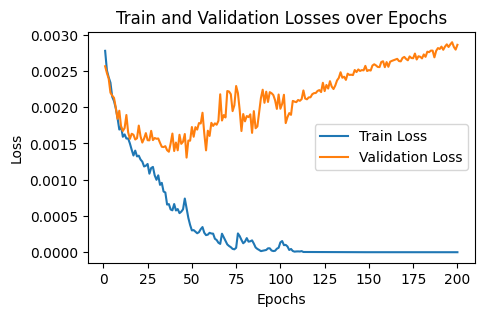

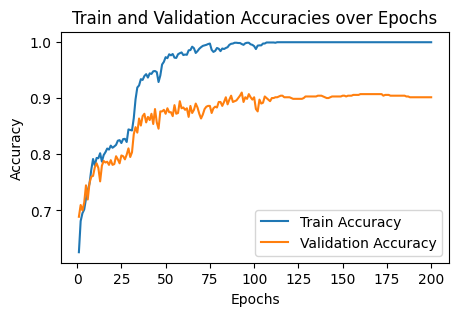

In [24]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [60]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/2000_GRU_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 3/3 [00:00<00:00, 408.97it/s]

Best epoch: 93
macro F1 Score: 0.8879551820728292
AUROC: 0.9525601456157011
Accuracy: 0.8879551820728291


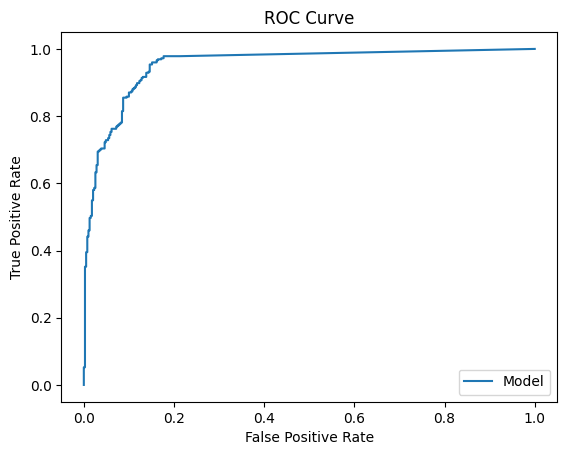

In [26]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)